In [ ]:
#OS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sksurv.meta import EnsembleSelection
from sksurv.svm import FastSurvivalSVM, FastKernelSurvivalSVM
from sksurv.tree import SurvivalTree
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, VarianceThreshold, RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn import set_config
import xgboost as xgb
import shap
import pickle
import time
from copy import deepcopy
from functools import cache
import warnings
warnings.filterwarnings("ignore")
randomState = 42 # tip of the cap to Douglas Adams
set_config(transform_output="pandas")
Verbosity = 0

In [2]:
fianl_clean_data = pd.read_pickle('fianl_clean_data.pkl')

In [3]:
fianl_clean_data.head

<bound method NDFrame.head of         cg13869341  cg24669183  cg15560884  cg01014490  cg17505339  \
369.0     0.839668    0.622626    0.724557    0.013253    0.954777   
96.0      0.887214    0.557666    0.709998    0.016885    0.909813   
423.0     0.878038    0.821218    0.665864    0.017920    0.925042   
370.0     0.857886    0.765783    0.677472    0.008228    0.952425   
459.0     0.851489    0.727787    0.790580    0.011233    0.909230   
...            ...         ...         ...         ...         ...   
1097.0    0.916326    0.895041    0.689632    0.016836    0.931332   
1101.0    0.888906    0.668552    0.649029    0.016283    0.924404   
781.0     0.870023    0.920880    0.748541    0.017143    0.889875   
782.0     0.842035    0.886402    0.708638    0.019360    0.936385   
1089.0    0.837559    0.884514    0.680507    0.022893    0.913718   

        cg11954957  cg16736630  cg05898754  cg03128332  cg16619049  ...  \
369.0     0.778680    0.937495    0.574408    0.256935

In [ ]:
# break out the target
# print(mergeSurvivalClinicalGene.describe())
y = fianl_clean_data[['OS']]
# y['OSBool'] = y.OS.astype(bool) # this is the format scikit-survival needs
fianl_clean_data.drop(columns=['OS'], inplace=True)
# mergeSurvivalClinicalGene.describe().

In [62]:
X_train, X_test, y_train, y_test = train_test_split(fianl_clean_data, y, test_size=0.2, random_state=randomState, stratify=y)

if Verbosity > 0:
    print('X_train', X_train.shape), print('y_train', y_train.shape)
    # print(np.bincount(y_train))
    print('X_test', X_test.shape), print('y_test', y_test.shape)
    # print(np.bincount(y_test))

In [63]:
# now that we've split and stratified, supplement y with other elements of target
y['OS.time'] = fianl_clean_data['OS.time']
y_train['OS.time'] = X_train['OS.time']
y_test['OS.time'] = X_test['OS.time']
fianl_clean_data.drop(columns='OS.time', inplace=True)
X_train.drop(columns='OS.time', inplace=True)
X_test.drop(columns='OS.time', inplace=True)
# yOS_train = [[y_train, X_train['OS.time']]
# yOS_train = [[y_test, X_test['OS.time']]

In [64]:
# create boolean target that scikit-survival needs
y['OSBool'] = y.OS.astype(bool)
y_train['OSBool'] = y_train.OS.astype(bool)
y_test['OSBool'] = y_test.OS.astype(bool)

In [65]:
# convert OS.time from days to months
# this makes charts easier to interpret
y['OS.time.months'] = y['OS.time'] / 30.417

if Verbosity > 0:
    y['OS.time.months']

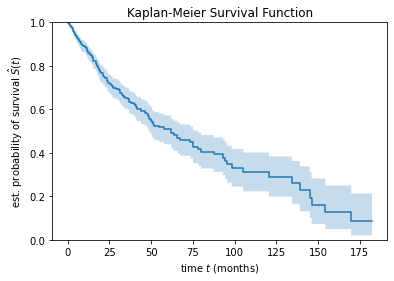

In [66]:
# Create Kaplan-Meier Survival Function for the entire dataset
%matplotlib inline
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator

surv_time, survival_prob, conf_int = kaplan_meier_estimator(
    y.OSBool, y['OS.time.months'], conf_type="log-log"
    # data_y["Status"], data_y["Survival_in_days"], conf_type="log-log"
)
plt.step(surv_time, survival_prob, where="post")
plt.fill_between(surv_time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.title('Kaplan-Meier Survival Function')
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$ (months)")
plt.savefig("Kaplan-Meier Survival Function.png")

In [67]:
# function to format target for Scikit-Survival
#
def format_target_for_Scikit_Survival(y):
    # y: event boolean and event time, eg. y_train[['OSBool', 'OS.time']]
    # List of tuples
    aux = [(e1,e2) for e1,e2 in np.array(y)]
    # aux = [(e1,e2) for e1,e2 in np.array(y[['OSBool', 'OS.time']])]

    #Structured array
    yOS = np.array(aux, dtype=[('Status', '?'), ('Survival_in_months', '<f8')])
    # print(yOS)

    return yOS

In [68]:
# format target for Scikit-Survival

#Structured array
yOS = format_target_for_Scikit_Survival(y[['OSBool', 'OS.time']])
if Verbosity > 0:
    yOS

In [69]:
# format target for Scikit-Survival
yOS_train = format_target_for_Scikit_Survival(y_train[['OSBool', 'OS.time']])
if Verbosity > 0:
    yOS_train

yOS_test = format_target_for_Scikit_Survival(y_test[['OSBool', 'OS.time']])
if Verbosity > 0:
    yOS_test

In [70]:
# function to create additional target at 'years' years in to the study
def create_target_year(X, y, years):
    OSBinary = []
    OSTimeMonths = []

    for sample_idx in range(len(y)):
        # print(y.iloc[sample_idx])
        if y.iloc[sample_idx]['OS.time.months'] <= (years * 12):
            # print('In Cohort, OS= ', y.iloc[sample_idx].OS)
            OSBinary.append(y.iloc[sample_idx].OS)
            OSTimeMonths.append(y.iloc[sample_idx]['OS.time.months'])
        else:
            OSBinary.append(0) # censored
            OSTimeMonths.append(years * 12)

    OSBinary = pd.Series(OSBinary)
    OSBool = OSBinary.astype(bool)
    OSTimeMonths = pd.Series(OSTimeMonths)

    # create balanced test and train sets
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, OSBinary, test_size=0.2, random_state=randomState, stratify=OSBinary)

    if Verbosity > 0:
        print('ytrain: ', np.bincount(ytrain))
        print('ytrain: ', ytrain)
        print('ytest: ', np.bincount(ytest))
        print('ytrain: ', ytrain)

    return Xtrain, Xtest, ytrain, ytest, OSBinary, OSBool, OSTimeMonths

In [71]:
y.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
OS,578.0,0.326990,0.469520,0.0,0.000000,0.000000,1.000000,1.000000
OS.time,578.0,841.141869,864.070960,0.0,304.000000,577.500000,1094.000000,5546.000000
OS.time.months,578.0,27.653676,28.407501,0.0,9.994411,18.986093,35.966729,182.332248


In [72]:
# create 1, 3, 5 year targets

y_timeframes = []

Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths = create_target_year(fianl_clean_data, y, 1)
y_timeframes += [['Year1', Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths]]
# y_timeframes += [['Year1', y['OSYear1'], y['OSYear1.time.months'], y['OSYear1Bool']]]

Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths = create_target_year(fianl_clean_data, y, 3)
y_timeframes += [['Year3', Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths]]
# y['OSYear3'], y['OSYear3Bool'], y['OSYear3.time.months'] = create_target_year(y, 3)
#y_timeframes += [['Year3', y['OSYear3'], y['OSYear3.time.months'], y['OSYear3Bool']]]

Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths = create_target_year(fianl_clean_data, y, 5)
y_timeframes += [['Year5', Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths]]
# y['OSYear5'], y['OSYear5Bool'], y['OSYear5.time.months'] = create_target_year(y, 5)
# y_timeframes += [['Year5', y['OSYear5'], y['OSYear5.time.months'], y['OSYear5Bool']]]

Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths = create_target_year(fianl_clean_data, y, 7)
y_timeframes += [['Year7', Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths]]

y_timeframes += [['End Of Study', X_train, X_test, y_train.OS, y_test.OS, y.OS, y.OSBool, y['OS.time.months']]]
# print('ytrain: ', np.bincount(y_train))
# print('ytest: ', np.bincount(y_test))

# y_timeframes

In [73]:
# Iterate through each time frame in y_timeframes
for timeframe_name, Xtrain, Xtest, ytrain, ytest, yOSBinary, yOSBool, yOSTimeMonths in y_timeframes:
    print(f"Timeframe: {timeframe_name}")
    print(f"OS.time.months: {yOSTimeMonths.describe()}")
    print("=" * 50)  # Just to separate each timeframe with a line

Timeframe: Year1
OS.time.months: count    578.000000
mean      10.085170
std        3.548388
min        0.000000
25%        9.994411
50%       12.000000
75%       12.000000
max       12.000000
dtype: float64
Timeframe: Year3
OS.time.months: count    578.000000
mean      20.359718
std       12.195458
min        0.000000
25%        9.994411
50%       18.986093
75%       35.868396
max       36.000000
dtype: float64
Timeframe: Year5
OS.time.months: count    578.000000
mean      23.985639
std       17.947579
min        0.000000
25%        9.994411
50%       18.986093
75%       35.966729
max       60.000000
dtype: float64
Timeframe: Year7
OS.time.months: count    578.000000
mean      25.802246
std       22.131177
min        0.000000
25%        9.994411
50%       18.986093
75%       35.966729
max       84.000000
dtype: float64
Timeframe: End Of Study
OS.time.months: count    578.000000
mean      27.653676
std       28.407501
min        0.000000
25%        9.994411
50%       18.986093
75%     

In [74]:
for name, frame in zip(["Year1", "Year3", "Year5", "Year7", "End of Study"], y_timeframes):
    print(f"Data for {name}:")
    _, Xtrain, Xtest, ytrain, ytest, _, _, _ = frame
    print("  Training data shape:", Xtrain.shape)
    print("  Testing data shape:", Xtest.shape)
    print("  Training target distribution:", np.bincount(ytrain))
    print("  Testing target distribution:", np.bincount(ytest))


Data for Year1:
  Training data shape: (462, 403965)
  Testing data shape: (116, 403965)
  Training target distribution: [407  55]
  Testing target distribution: [102  14]
Data for Year3:
  Training data shape: (462, 403965)
  Testing data shape: (116, 403965)
  Training target distribution: [348 114]
  Testing target distribution: [87 29]
Data for Year5:
  Training data shape: (462, 403965)
  Testing data shape: (116, 403965)
  Training target distribution: [329 133]
  Testing target distribution: [83 33]
Data for Year7:
  Training data shape: (462, 403965)
  Testing data shape: (116, 403965)
  Training target distribution: [321 141]
  Testing target distribution: [81 35]
Data for End of Study:
  Training data shape: (462, 403965)
  Testing data shape: (116, 403965)
  Training target distribution: [311 151]
  Testing target distribution: [78 38]


In [75]:
# utility pipeline debugging class
from sklearn.base import TransformerMixin, BaseEstimator

class Debug(BaseEstimator, TransformerMixin):

    def transform(self, X):
        if Verbosity > 0:
            print('--- Debug transform -------------------------------------------------------------\n')
            print('X: ', X.shape)
            print('X: \n', pd.DataFrame(X).head())
        return X

    def fit(self, X, y=None, **fit_params):
        if Verbosity > 0:
            print('--- Debug fit -------------------------------------------------------------\n')
            print('X: ', X.shape)
            print('X: \n', pd.DataFrame(X).head())
            with open('X.pkl', 'wb') as f:
                pickle.dump(X, f)
            print('y: ', y.shape)
            print('y: \n', pd.DataFrame(y).head())
            with open('y.pkl', 'wb') as f:
                pickle.dump(y, f)
        return self

In [76]:
# Assuming clinical_info is a pandas DataFrame already loaded

# Select columns where dtype is 'object'
object_columns = fianl_clean_data.select_dtypes(include=['object']).columns
nomFeatureColNames=[]
# Convert the Index object to a list
nomFeatureColNames = object_columns.tolist()

# Print the list of column names
# nomFeatureColNames.remove('Unnamed: 0')
# nomFeatureColNames.remove('ID')
# nomFeatureColNames.remove('rec_ID')

print("Columns with dtype 'object':", nomFeatureColNames)


Columns with dtype 'object': []


In [77]:
# encoding nominal features...,
# nomFeatureColNames = ['Sex', 'Smoking_2groups','T','N','M','EGFR_mut','Co-mut','']
# nomFeatureColNames += ['breast_carcinoma_surgical_procedure_name', 'PAM50Call_RNAseq', 'PAM50_mRNA_nature2012', '_PANCAN_CNA_PANCAN_K8', 'histological_type', 'new_neoplasm_event_type', 'tissue_source_site' ]
# nomFeatureColNames += ['PAM50_mRNA_nature2012', '_PANCAN_CNA_PANCAN_K8', 'histological_type', 'new_neoplasm_event_type', 'tissue_source_site']
nominal_categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(sparse_output=False)),
        # ('dbg', Debug()),
        # ("selector", SelectPercentile(chi2, percentile=50)),
    ],
    verbose=Verbosity
)

In [78]:
# Assuming clinical_info is a pandas DataFrame already loaded

# Select columns where dtype is 'object'
numeric_columns = fianl_clean_data.select_dtypes(exclude=['object']).columns
listOfNumericalColNames=[]
# Convert the Index object to a list
listOfNumericalColNames = numeric_columns.tolist()

# Print the list of column names

# listOfNumericalColNames.remove('OS.time')
print("Columns with dtype 'object':", listOfNumericalColNames)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [79]:

# print(listOfNumericalColNames.count('T'))
numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler()),
    # ('dbg', Debug())
    ],
    verbose=Verbosity
)
# mergeSurvivalClinicalGene.count('T')
# listOfNumericalColNames.remove('OS')
numericColsWithNans = pd.DataFrame(fianl_clean_data[listOfNumericalColNames].isna().sum()[lambda x : x > 0])

numericColsWithNans.set_index(numericColsWithNans.index.astype(str), inplace=True)
# numericColsWithNans.set_index('num__' + numericColsWithNans.index.astype(str), inplace=True)
if Verbosity > 0:
    print('\nnumericColsWithNans: ', numericColsWithNans)

In [80]:
# utility pipeline class for removing columns containing any NaN
# to prepare data for models that cannot handle missing data
class RemoveColsWithNan(BaseEstimator, TransformerMixin):

    def transform(self, X):
        if Verbosity > 0:
            print('X.shape: ', X.shape)
            # print('X type: ', type(X))
        X.drop(columns=numericColsWithNans.index, inplace=True)
        if Verbosity > 0:
            print('\nNaNCols\n', numericColsWithNans.index)
            print('\nDropped ', numericColsWithNans.shape[0], ' columns\n')
            print('X.shape: ', X.shape)
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [81]:
# data pre-processor
preprocessor = ColumnTransformer(
    transformers=[
        ("passthru", 'passthrough', listOfNumericalColNames),
        # ("cat_ord", ordinal_categorical_transformer, ordFeatureColNames),
        # ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), [3]),
        ("cat_nom", nominal_categorical_transformer, nomFeatureColNames)
        # remainder='passthrough'
        # ("pass_through", 'passthrough', listOfReadyColNames),
    ],
    verbose_feature_names_out=False,
    verbose=Verbosity,
)

In [82]:
# data pre-processor
# def all_cols_selector(X):
#     print(list(X.columns))
#     return list(X.columns)

scaler = ColumnTransformer(
    transformers=[
        ("scaler", numeric_transformer, make_column_selector()),
    ],
    verbose_feature_names_out=False,
    verbose=Verbosity,
)

In [84]:
# function to calculate feature importances for Cox PH algorithm
def cox_fit_and_score_features(X, y):
    n_features = X.shape[1]
    last_y = y
    if Verbosity > 0:
        print('n_features: ', n_features)
    coxScores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis(alpha=0.1, verbose=0)
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        if Verbosity > 0:
            print(j, end=',')
        coxScores[j] = m.score(Xj, y)

    with open('coxScores.pkl', 'wb') as f:
        pickle.dump(coxScores, f)

    if Verbosity > 0:
        print('\nFinished fitting and scoring\n')
    return coxScores

In [85]:
# plot model evaluation results across target time horizons
def plot_results(models_results, y_timeframes, verbosity):

    x = np.arange(len(models_results['XGB']['timeframes'].keys()))  # the label locations

    cIndex_vals = {}
    for model in models_results.keys():
        cIndex_vals[model] = []

    for target in models_results['XGB']['timeframes'].keys():
        if verbosity > 0:
            print(target)
            # print(models_results[model]['timeframes'].keys())

        for model in models_results.keys():
            if verbosity > 0:
                print(model)
                print(models_results[model]['timeframes'][target]['cIndex_test'])
            cIndex_vals[model].append(models_results[model]['timeframes'][target]['cIndex_test'])

    print(cIndex_vals)

    for model, measurement in cIndex_vals.items():
        plt.plot(x, measurement, label=model)


    # Add some text for labels, title and custom x-axis tick labels, etc.
    plt.ylabel("concordance index")
    plt.xlabel("analysis target timeframe")
    plt.xticks(x, models_results['XGB']['timeframes'].keys())
    plt.legend(loc="best")
    plt.title('Survival Prediction Accuracy by Time Horizon')
    plt.show()

    return

In [86]:
models_results = {}

In [87]:
# yBool_length = len(y_train.OSBool)
# yOSTime_length = len(X_train.OS_Time_nature2012)
y_train.info()
# Assuming y_train is a pandas DataFrame already loaded

# Rename the 'OS.time' column to 'OS_time'
y_train = y_train.rename(columns={'OS.time': 'OS_time'})

# Optionally, check the change by printing the DataFrame info to confirm the rename
print(y_train.info())


<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 449.0 to 352.0
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   OS       462 non-null    float64
 1   OS.time  462 non-null    float64
 2   OSBool   462 non-null    bool   
dtypes: bool(1), float64(2)
memory usage: 11.3 KB
<class 'pandas.core.frame.DataFrame'>
Index: 462 entries, 449.0 to 352.0
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   OS       462 non-null    float64
 1   OS_time  462 non-null    float64
 2   OSBool   462 non-null    bool   
dtypes: bool(1), float64(2)
memory usage: 11.3 KB
None


In [88]:
yBool_length = len(y_train.OSBool)
yOSTime_length = len(y_train.OS_time)

print(f"Length of yBool: {yBool_length}")
print(f"Length of yOSTime: {yOSTime_length}")

Length of yBool: 462
Length of yOSTime: 462


In [90]:
valid_indices = [index for index in ytrain.index if index < yBool_length and index < yOSTime_length]
ytrain_filtered = ytrain[valid_indices]


In [91]:
print("Length of ytest.index:", len(ytest.index))
print("Length of yBool:", yBool_length)
print("Length of yOSTime:",yOSTime_length)

Length of ytest.index: 116
Length of yBool: 462
Length of yOSTime: 462


In [92]:
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable


In [93]:
# data pre-processor
preprocessor = ColumnTransformer(
    transformers=[
        ("passthru", 'passthrough', listOfNumericalColNames),
        # ("cat_ord", ordinal_categorical_transformer, ordFeatureColNames),
        # ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), [3]),
        ("cat_nom", nominal_categorical_transformer, nomFeatureColNames)
        # remainder='passthrough'
        # ("pass_through", 'passthrough', listOfReadyColNames),
    ],
    verbose_feature_names_out=False,
    verbose=Verbosity,
)

In [96]:
import xgboost as xgb


In [97]:
# train and score "vanilla" algorithms against each each time horizon...1, 3, 5, end of study
# takes ~? minutes
# Verbosity = 1
start_time = time.time() # start the timer
classifiers = [
    ['Log Reg', LogisticRegression(verbose=Verbosity,
                                   random_state=randomState)],
    ['XGB', xgb.XGBClassifier(objective="binary:logistic",
                              verbosity=Verbosity,
                              reg_lambda=5.0,
                              random_state=randomState,
                              max_depth=4,
                              min_child_weight=6,
                              subsample=0.8,
                              colsample_bytree=0.8,
                              n_estimators=1000,
                              learning_rate=0.01,
                              enable_categorical=True)],
    # ['MLP', MLPClassifier(max_iter=300, verbose=Verbosity, random_state=randomState)],
#    ['SVM', SVC(kernel='linear',probability=True, verbose=True, random_state=randomState)],
#    ['HistGB', HistGradientBoostingClassifier(verbose=Verbosity)],
    # ['SVM', LinearSVC(verbose=True, random_state=randomState)]
    ]




steps = [
#         ('preprocess', preprocessor),
        ('scaler', scaler),
#         ("stripNaNCols", RemoveColsWithNan()),
        ("selectK", SelectKBest(k=25)),
        # ("dump", Dump()),
        # ('select', fs),
]
pipeline = Pipeline(steps, memory='/kaggle/working/mInfoPipecache', verbose=Verbosity)

for name, classifier in classifiers:
    pipeline.steps.append(['selectRFECV', RFECV(estimator=deepcopy(classifier), step=1, verbose=Verbosity)])
    pipeline.steps.append(['clf', classifier])
    models_results[name] = {'model': classifier}
    models_results[name]['pipeline'] = deepcopy(pipeline)
    models_results[name]['timeframes'] = {}

    for timeframe_name, Xtrain, Xtest, ytrain, ytest, y, yBool, yOSTime in y_timeframes:
        models_results[name]['timeframes'][timeframe_name] = {}
        tf = models_results[name]['timeframes'][timeframe_name]

#         cv_refcv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=randomState)
#         n_scores = cross_val_score(pipeline, mergeSurvivalClinicalGene, y, scoring='accuracy', cv=cv_refcv, n_jobs=-1)
#         print('Accuracy: %.2f (%.2f)'% (np.mean(n_scores), np.std(n_scores)))

        print('\nFit Model: ', classifier, '---------------------------------------------')
        print('\nTarget: ', timeframe_name, '---------------------------------------------')
        pipeline.fit(Xtrain, ytrain)

        # Score the model against train set
        print('\nScore Model on Training Set: ', classifier, '---------------------------------------------')
        tf['train_score'] = pipeline.score(Xtrain, ytrain)
        print("model score train: %.3f" % tf['train_score'])

        # predict against train set
        yHat_train = pipeline.predict(Xtrain)
        tf['yHat_train'] = yHat_train

        # predict probabilities, not just binary
        yHat_train_prob = pipeline.predict_proba(Xtrain)
        tf['yHat_train_prob'] = yHat_train_prob

        # Score the model against Test Set
        print('\nScore Model on Test Set: ', classifier, '---------------------------------------------')
        tf['test_score'] = pipeline.score(Xtest, ytest)
        print("model score: %.3f" % tf['test_score'])

        # predict against test set
        yHat_test = pipeline.predict(Xtest)
        tf['yHat_test'] = yHat_test
        tf['test_f1_score'] = f1_score(ytest, yHat_test)

        # predict probabilities, not just binary
        yHat_test_prob = pipeline.predict_proba(Xtest)
        tf['yHat_test_prob'] = yHat_test_prob

        # Score model performance as Concordance Index against Test Set
        # Safe handling of indices when accessing yBool and yOSTime
        safe_yBool = yBool.loc[ytest.index.intersection(yBool.index)]
        safe_yOSTime = yOSTime.loc[ytest.index.intersection(yOSTime.index)]

        try:
            tf['cIndex_test'] = concordance_index_censored(
                safe_yBool,
                safe_yOSTime,
                yHat_test_prob[:, 1])[0]
            print('cIndex_test: ', tf['cIndex_test'])
        except Exception as e:
            print("Error calculating cIndex_test:", e)

        tf['pipeline'] = deepcopy(pipeline)
        tf['model'] = deepcopy(classifier)

    pipeline.steps.pop(-1)
    pipeline.steps.pop(-1)

print('%s seconds' % (time.time() - start_time))


Fit Model:  LogisticRegression(random_state=42) ---------------------------------------------

Target:  Year1 ---------------------------------------------

Score Model on Training Set:  LogisticRegression(random_state=42) ---------------------------------------------
model score train: 0.944

Score Model on Test Set:  LogisticRegression(random_state=42) ---------------------------------------------
model score: 0.905
cIndex_test:  0.8899213724088635

Fit Model:  LogisticRegression(random_state=42) ---------------------------------------------

Target:  Year3 ---------------------------------------------

Score Model on Training Set:  LogisticRegression(random_state=42) ---------------------------------------------
model score train: 0.959

Score Model on Test Set:  LogisticRegression(random_state=42) ---------------------------------------------
model score: 0.940
cIndex_test:  0.9014084507042254

Fit Model:  LogisticRegression(random_state=42) ---------------------------------------


Score Model on Training Set:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=6, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...) ---------------------------------------------
model score train: 0.972

Score Model on Test Set:  XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
 